In [46]:
import torch
import echotorch
import echotorch.nn.reservoir as etrs
from torch.autograd import Variable
from torch.utils.data.dataloader import DataLoader
import numpy as np
import json
    
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from utils import *

def build_model(prediction_horizon, interval):
    # Manual seed initialisation
    np.random.seed(1)
    torch.manual_seed(1)

    # Reservoir hyper-parameters
    input_dim = 1
    output_dim = 1

    # Read best hyperparams from JSON
    with open(f'hyperparams/hyperparams_esn_{interval}.json', 'r') as fp:
        params = json.load(fp)

    spectral_radius = params['spectral_radius']
    # leaky_rate = params['leaky_rate']
    reservoir_size = int(params['reservoir_size'])
    connectivity = params['connectivity']
    ridge_param = params['ridge_param']
    input_scaling = params['input_scaling']
    bias_scaling = params['bias_scaling']

    batch_size = 1 

    # Internal matrix
    w_generator = echotorch.utils.NormalMatrixGenerator(
        connectivity=connectivity,
        spetral_radius=spectral_radius
    )

    # Input weights
    win_generator = echotorch.utils.NormalMatrixGenerator(
        connectivity=connectivity,
        scale=input_scaling,
        apply_spectral_radius=False
    )

    # Bias vector
    wbias_generator = echotorch.utils.NormalMatrixGenerator(
        connectivity=connectivity,
        scale=bias_scaling,
        apply_spectral_radius=False
    )

    esn = etrs.ESN(
        input_dim=input_dim,
        hidden_dim=reservoir_size,
        output_dim=output_dim,
        learning_algo='inv',
        w_generator=w_generator,
        win_generator=win_generator,
        wbias_generator=wbias_generator,
        ridge_param=ridge_param
    )
    # data parameters
    window_size = 1

    ds_builder = DatasetBuilder()
    X_train, y_train, X_test, y_test = ds_builder.build_dataset_simple(prediction_horizon, interval, data_path='../data/input_data.csv', train_pct=0.8)

    dataset_train = MyDataset(X_train, y_train)
    dataset_test = MyDataset(X_test, y_test)

    trainloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
    testloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    for data in trainloader:
        # Inputs and outputs
        inputs, targets = data

        # Transform data to Variables
        inputs, targets = Variable(inputs), Variable(targets)

        # ESN need inputs and targets
        esn(inputs, targets)
    # Now we finalize the training by

    # computing the output matrix Wout.
    esn.finalize()

    # Train MSE
    dataiter = iter(trainloader)
    train_u, train_y = dataiter.next()
    train_u, train_y = Variable(train_u), Variable(train_y)
    y_predicted = esn(train_u)
#     print(u"Train RMSE: {}".format(echotorch.utils.rmse(y_predicted.data, train_y.data)))

    # Test MSE
    dataiter = iter(testloader)
    test_u, test_y = dataiter.next()
    test_u, test_y = Variable(test_u), Variable(test_y)
    y_predicted = esn(test_u)
    y_predicted = ds_builder.unscale_y(y_predicted.data)
    test_y = ds_builder.unscale_y(test_y.data)
#     print(u"Test RMSE: {}".format(echotorch.utils.rmse(y_predicted, test_y)))
    
    return echotorch.utils.rmse(y_predicted, test_y), y_predicted, test_y

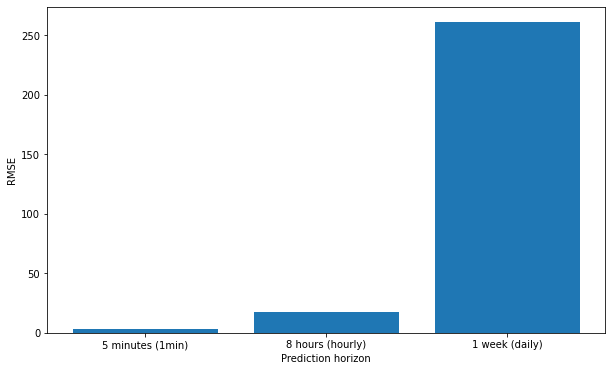

In [47]:
prediction_horizons = [5, 8, 7]
intervals = ['1min', '60min', 'daily']
ahead = ['5 minutes (1min)', '8 hours (hourly)', '1 week (daily)']

results = {interval:{'y_pred':None, 'y_test':None} for interval in intervals}
rmse = []
for prediction_horizon, interval in zip(prediction_horizons, intervals):
#     print(interval)
    rmse_, y_predicted, y_test = build_model(prediction_horizon, interval)
    rmse.append(rmse_)
    results[interval]['y_pred'] = y_predicted
    results[interval]['y_test'] = y_test
#     print()


fig = plt.figure(figsize=(10, 6))
plt.bar(ahead, rmse)

plt.xlabel('Prediction horizon')
plt.ylabel('RMSE')
# plt.title(param)
plt.show()

# Predictions plot

In [48]:
def plot(interval, prediction_horizon):
    y_predicted = results[interval]['y_pred']
    test_y = results[interval]['y_test']

    # Show target and predicted
    start_idx = prediction_horizon
    target = test_y[0, start_idx:-1, 0]
    pred_esn = y_predicted[0, start_idx:-1, 0]
    pred_target_step_before = test_y[0, :-prediction_horizon-1, 0]
    pred_arima = pd.read_csv(f'predictions_arima/predictions_{interval}.csv').values[2:, 1]
    
    if'daily' in interval:
        pred_arima = pred_arima[1:]

    plt.figure(figsize=(16, 6))
    plot_start = 0
    plot_end = min(50, test_y.shape[1])

#     plt.plot(pred_esn[plot_start:plot_end], 'black')
#     plt.plot(target[plot_start:plot_end], 'r')
#     plt.legend(['ESN', 'target(t)'])
    plt.plot(pred_esn[plot_start:plot_end], 'black')
    plt.plot(target[plot_start:plot_end], 'r')
    # prediction=target(t-1)
    plt.plot(pred_target_step_before[plot_start:plot_end], 'b')
    plt.plot(pred_arima[plot_start:plot_end], 'green')
    plt.legend(['ESN', 'target(t)', f'target(t-{prediction_horizon})', 'ARIMA'])
    plt.xticks(list(range(0, plot_end-plot_start)), list(range(plot_start, plot_end)))
    plt.show()


    plt.figure(figsize=(16, 6))
    plot_start = 0
    plot_end = min(320, test_y.shape[1])

    plt.plot(pred_esn[plot_start:plot_end], 'black')
    plt.plot(target[plot_start:plot_end], 'r')
    # prediction=target(t-1)
    plt.plot(pred_target_step_before[plot_start:plot_end], 'b')
    plt.plot(pred_arima[plot_start:plot_end], 'green')
    plt.legend(['ESN', 'target(t)', f'target(t-{prediction_horizon})', 'ARIMA'])
#     plt.xticks(list(range(0, plot_end-plot_start)), list(range(plot_start, plot_end)))
    plt.show()


    errors = pd.DataFrame([], columns=['Model', 'RMSE'])
    error = mean_squared_error(target, pred_arima, squared=False)
    errors = errors.append({'Model': 'ARIMA', 'RMSE':error}, ignore_index=True)

    error = mean_squared_error(target, pred_esn, squared=False)
    errors = errors.append({'Model': 'ESN', 'RMSE':error}, ignore_index=True)

    error = mean_squared_error(target, pred_target_step_before, squared=False)
    errors = errors.append({'Model': f'baseline (t-{prediction_horizon})', 'RMSE':error}, ignore_index=True)

    errors = errors.sort_values(by='RMSE')
    print(errors)
    print()
    print()

Prediction horizon:  5 minutes (1min)


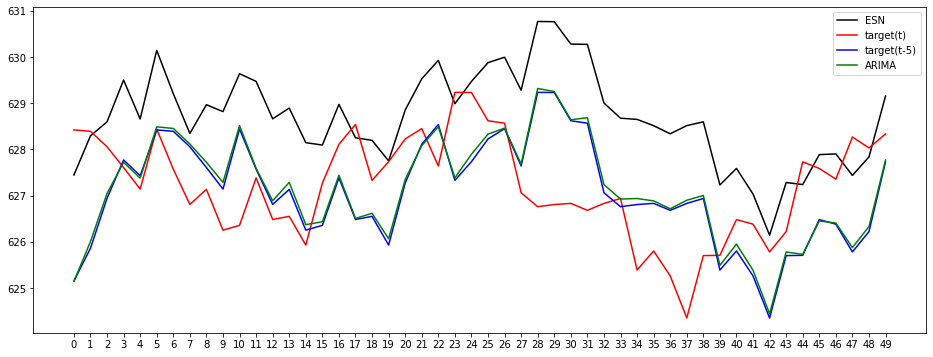

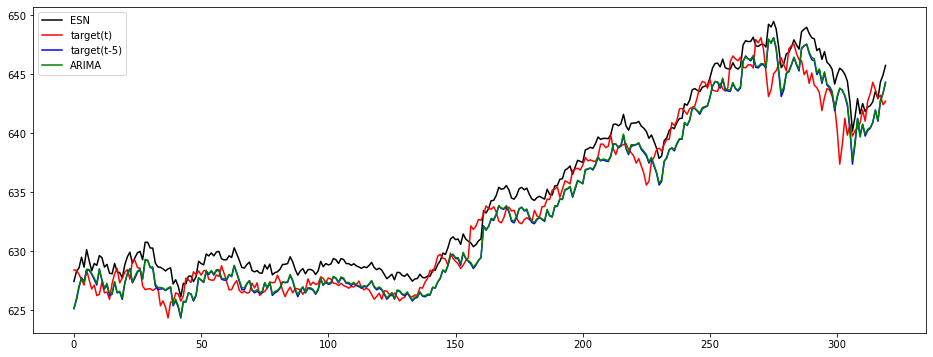

            Model      RMSE
2  baseline (t-5)  2.745241
0           ARIMA  2.757300
1             ESN  3.053052


Prediction horizon:  8 hours (hourly)


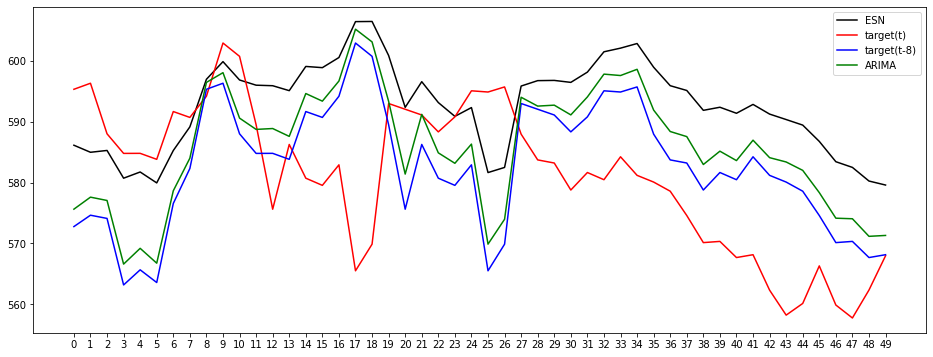

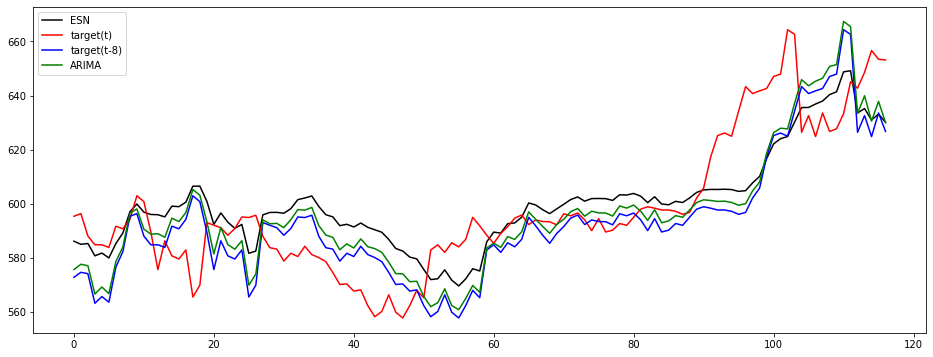

            Model       RMSE
1             ESN  16.426189
0           ARIMA  16.723980
2  baseline (t-8)  17.382456


Prediction horizon:  1 week (daily)


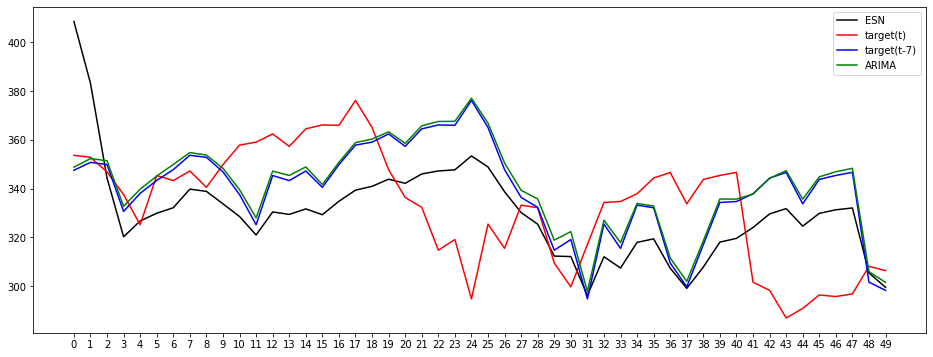

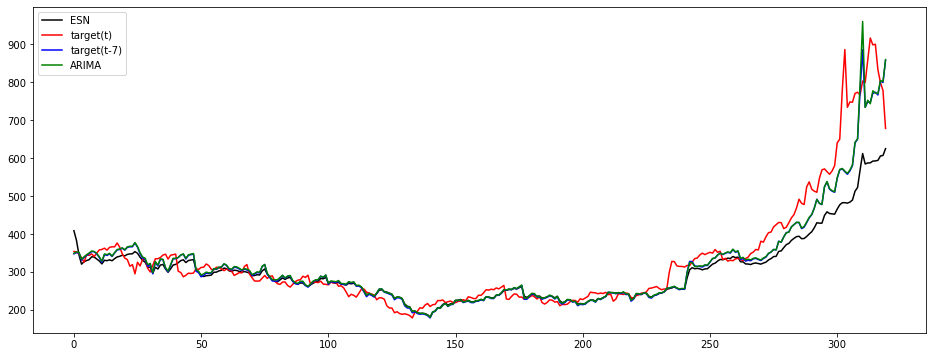

            Model        RMSE
2  baseline (t-7)  219.930054
0           ARIMA  227.889838
1             ESN  262.471924




In [49]:
for i, (prediction_horizon, interval) in enumerate(zip(prediction_horizons, intervals)):
    print('Prediction horizon: ', ahead[i])
    plot(interval, prediction_horizon)